# ICA with Spatial Binning (unsuccessful so far) - Asymm nonG
#### Working with Gaussian random field (GRF) + asymmetrical nonG field

## Set parameters

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats

# Parameters
logtwo_N = 20
N = 2**logtwo_N
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02 
A0 = (7.96*10**-10)# * 2*np.pi**2)
ns = 0.965
seed = 50
dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)
Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3

# Other NG parameters
alpha = 1.0
nu = 2
c, w = 2, .2

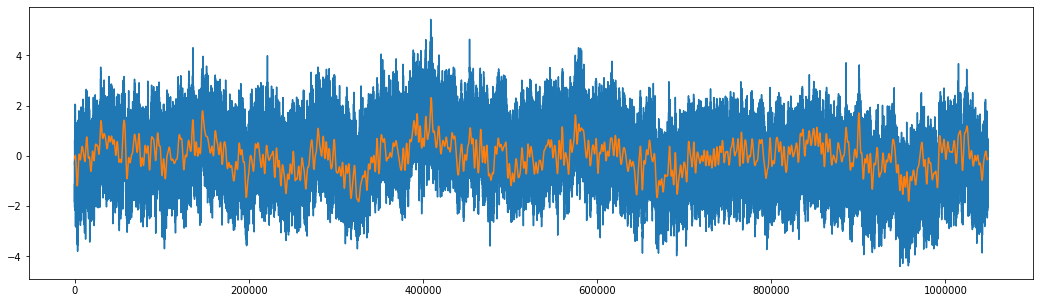

In [16]:
# Generate the grfs using gaussianfield
gg = grf.gaussian_random_field_1D(N, BoxSize=N, seed=seed)
ff = grf.gaussian_random_field_1D(N, BoxSize=N, seed=10000)

kc = np.logspace(0, logtwo_N-1, num=10, base=2.0)
kc_size = kc.size

g = grf.window(gg, N, kc[0], kc[4])
f = grf.window(ff, N, kc[0], kc[4])

plt.figure(figsize=(18,5))
plt.plot(ff)
plt.plot(f)

## Generate nonG fields

In [17]:
# Generate nonG fields

# Extract the standard deviation of the gaussian fields
s = g.std()
sf = f.std()

# Generate the non-gaussian components that will be added to the gaussian fields
# Note that 'g' is the field used to generate the NG components, so the NG
# is correlated with 'g', and 'f' is a different Gaussian random field with
# which the NG is uncorrelated
NG_symsinh = px.map_sinh(g, nu*s, alpha) - g
NG_asymsinh = px.map_asymm_sinh(g, nu*s, alpha) - g
NG_smooth_bump = px.map_smooth_bump(g, c, w) - g
NG_squared = g**2 - g

# Generate the correlated NG zeta fields 
zeta_NG_symsinh = g + NG_symsinh
zeta_NG_asymsinh = g + NG_asymsinh
zeta_NG_smooth_bump = g + NG_smooth_bump
zeta_NG_squared = g + g**2

# Generate the uncorrelated NG zeta fields 
zeta_NG_symsinh_uncorr = f + NG_symsinh
zeta_NG_asymsinh_uncorr = f + NG_asymsinh
zeta_NG_smooth_bump_uncorr = f + NG_smooth_bump
zeta_NG_squared_uncorr = f + g**2

# Test the asymmetric sinh function applied to a linear function tf
tf = np.linspace(-4, 4, N)
zeta_NG_asymsinh_test = px.map_asymm_sinh(tf, nu*s, alpha) - tf

# Generate gaussian distribution from mean and std of NG zeta fields
# ???

## Why are we getting an error for invalid value in power?

## Independent Component Analysis

$\texttt{sklearn}$ module contains contains a $\texttt{FastICA}$ capability. We can chose the cost function (measure of non-Gaussianity): $\texttt{cube}$ for kurtosis, and $\texttt{logcosh}$ for negentropy approximation.



In [18]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
import modules.colorednoise as cn

## Setup for dividing zeta(G) + zeta(NG) into two, and treating each half as a separate observed sample

In [27]:
# Note that 'g' is the field used to generate the NG component called 'NG_asymsinh', 
# so 'NG_asymsinh' is correlated with 'g', and 'f' is a different Gaussian random 
# field with which the 'NG_asymsinh' is uncorrelated. 

source_g = f
source_ng = NG_asymsinh
size_field = source_g.size
correlated = False

zeros = np.zeros(size_field//2)

source_g1 = source_g[:size_field//2]
source_g1 = np.concatenate((source_g1, zeros))

source_g2 = source_g[size_field//2:]
source_g2 = np.concatenate((zeros, source_g2))

source_ng1 = source_ng[:size_field//2]
source_ng1 = np.concatenate((source_ng1, zeros))

source_ng2 = source_ng[size_field//2:]
source_ng2 = np.concatenate((zeros, source_ng2))

source1 = source_g1 + source_ng1
source2 = source_g2 + source_ng2

num_comps = 2
num_samples = 2

mix_signal_pre = np.vstack([source1, source2])


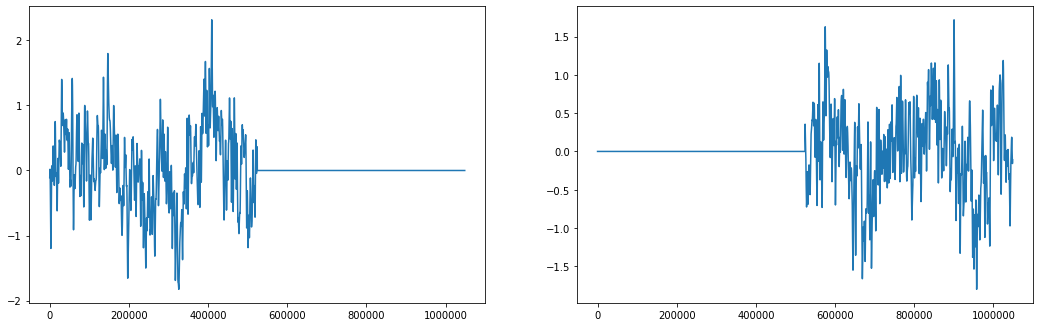

In [28]:
plt.figure(figsize=(18,12))

plt.subplot(221)
plt.plot(source_g1 + source_ng1)

plt.subplot(222)
plt.plot(source_g2 + source_ng2)

## Preprocess the fields

In [29]:
# Sample 1
sample1_pre = mix_signal_pre[0, :]
m1 = np.mean(sample1_pre)
sample1_ms = sample1_pre - m1

sample1_ft = np.fft.fft(sample1_ms)
sample1_sqrtpower = np.absolute(sample1_ft)

sample1_ms_white_ft = sample1_ft / sample1_sqrtpower * (size_field**(1/2))

sample1 = np.fft.ifft(sample1_ms_white_ft).real
sample1 = np.concatenate((sample1, zeros))

# Sample 2
sample2_pre = mix_signal_pre[1, :]
m2 = np.mean(sample2_pre)
sample2_ms = sample2_pre - m2

sample2_ft = np.fft.fft(sample2_ms)
sample2_sqrtpower = np.absolute(sample2_ft)

sample2_ms_white_ft = sample2_ft / sample2_sqrtpower * (size_field**(1/2))

sample2 = np.fft.ifft(sample2_ms_white_ft).real
sample2 = np.concatenate((zeros, sample2))

# Mix the samples back again
mix_signal = np.vstack([sample1, sample2])

# plt.figure(figsize=(18,5))
# plt.plot(sample1)

# plt.figure(figsize=(18,5))
# plt.plot(sample2)

## Plot the sources

Text(0, 0.5, 'Amplitude')

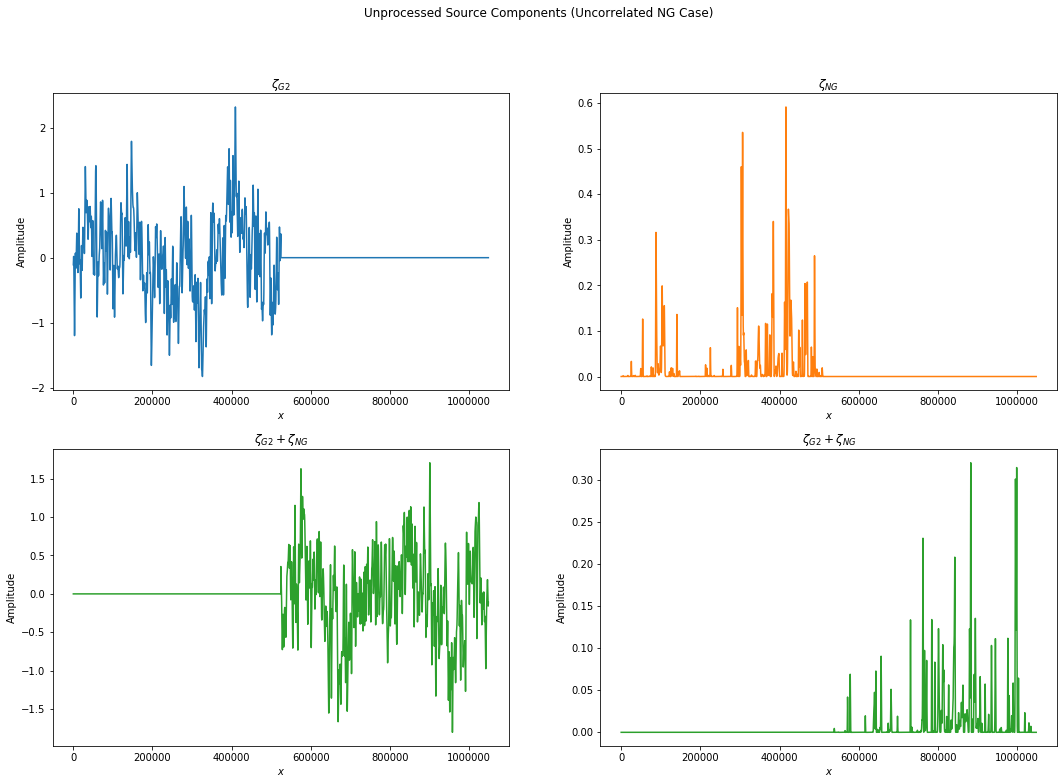

In [30]:
if correlated:
    k = 'G1'
    t = 'Correlated'
else:
    k = 'G2'
    t = 'Uncorrelated'
    
plt.figure(figsize=(18,12))
plt.suptitle(r'Unprocessed Source Components ({0} NG Case)'.format(t))

plt.subplot(221)
plt.plot(source_g1)
plt.title(r'$\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(source_ng1, color='C1')
plt.title(r'$\zeta_{NG}$')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(223)
plt.plot(source_g2, color='C2')
plt.title(r'$\zeta_{{{0}}}+\zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(224)
plt.plot(source_ng2, color='C2')
plt.title(r'$\zeta_{{{0}}}+\zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

## Plot the inputs

Text(0, 0.5, 'Amplitude')

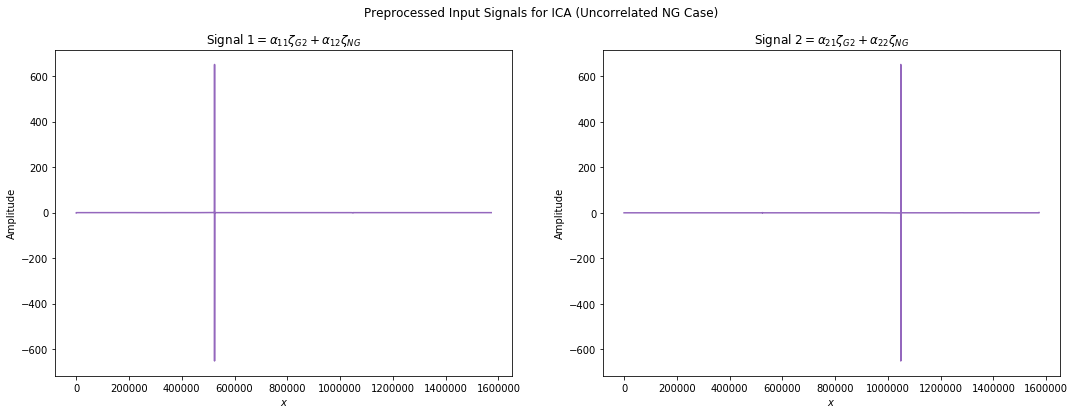

In [31]:
plt.figure(figsize=(18,6))
plt.suptitle(r'Preprocessed Input Signals for ICA ({0} NG Case)'.format(t))

plt.subplot(121)
plt.plot(sample1, color='C4')
plt.title(r'Signal 1$= \alpha_{{11}} \zeta_{{{0}}} + \alpha_{{12}} \zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(sample2, color='C4')
plt.title(r'Signal 2$=\alpha_{{21}} \zeta_{{{0}}} + \alpha_{{22}} \zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# if correlated:
#     plt.savefig('ICA_corr_mix.png')
# else:
#     plt.savefig('ICA_uncorr_mix.png')

## Apply $\texttt{FastICA}$

In [80]:
ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=10000, tol=1e-4, fun='cube')
sc = ica.fit_transform(mix_signal.T)

In [32]:
ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=100, tol=1e-3, fun='logcosh')
sl = ica.fit_transform(mix_signal_pre.T)

In [34]:
# Extract the individual components

kurt_scale1 = 120
kurt_scale2 = 900
negen_scale1 = -120
negen_scale2 = -900

# kurt_m1 = np.mean(sc[:, 0])
# kurt_m2 = np.mean(sc[:, 1])
# kurt_comp1 = -sc[:, 0]
# kurt_comp2 = -sc[:, 1]

negen_m1 = np.mean(sl[:, 0])
negen_m2 = np.mean(sl[:, 1])
negen_comp1 = sl[:, 0]
negen_comp2 = sl[:, 1]

## Plot extracted signals

In [35]:
# plt.figure(1, figsize=(20,8))

# for i in range(2):
#     plt.plot(sc[:, i]*110)
    
# plt.title('Kurtosis')

In [40]:
# # Kurtosis plots

# plt.figure(figsize=(18,5))
# plt.suptitle('Kurtosis')

# plt.subplot(121)
# plt.plot(kurt_comp2)
# plt.title(r'$\zeta_{{{0}}}$'.format(k))
# plt.xlabel(r'$x$')
# plt.ylabel("Amplitude")

# plt.subplot(122)
# plt.plot(kurt_comp1, color='C1')
# plt.title(r'$\zeta_{NG}$')
# plt.xlabel(r'$x$')
# plt.ylabel("Amplitude")

# # if correlated:
# #     plt.savefig('ICA_corr_kurtosis.png')
# # else:
# #     plt.savefig('ICA_uncorr_kurtosis.png')

Text(0, 0.5, 'Amplitude')

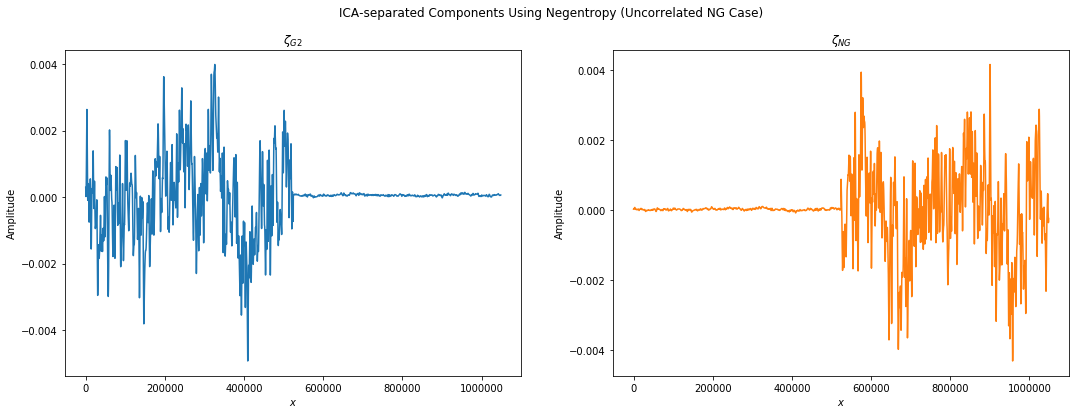

In [37]:
# Negentropy plots

plt.figure(figsize=(18,6))
plt.suptitle('ICA-separated Components Using Negentropy ({0} NG Case)'.format(t))

plt.subplot(121)
plt.plot(negen_comp2)
plt.title(r'$\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(negen_comp1, color='C1')
plt.title(r'$\zeta_{NG}$')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# if correlated:
#     plt.savefig('ICA_corr_negentropy.png')
# else:
#     plt.savefig('ICA_uncorr_negentropy.png')

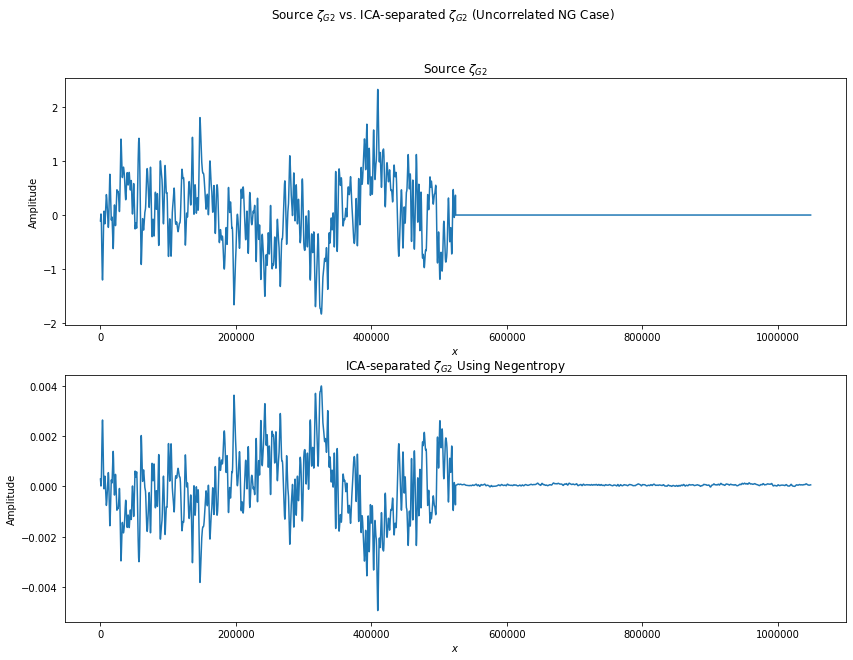

In [44]:
# Gaussian component plots

plt.figure(figsize=(14,10))
plt.suptitle(r'Source $\zeta_{{{0}}}$ vs. ICA-separated $\zeta_{{{0}}}$ (Uncorrelated NG Case)'.format(k))

# Original Gaussian component
plt.subplot(211)
plt.plot(source1)
plt.title(r'Source $\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# plt.subplot(212)
# plt.plot(kurt_comp2, color='C1')
# plt.title(r'$\zeta_{{{0}}}$ extracted using Kurtosis'.format(k))
# plt.xlabel(r'$x$')
# plt.ylabel("Amplitude")

plt.subplot(212)
plt.plot(negen_comp2)
plt.title(r'ICA-separated $\zeta_{{{0}}}$ Using Negentropy'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

if correlated:
    plt.savefig('ICA_corr_g.png')
else:
    plt.savefig('ICA_uncorr_g.png')

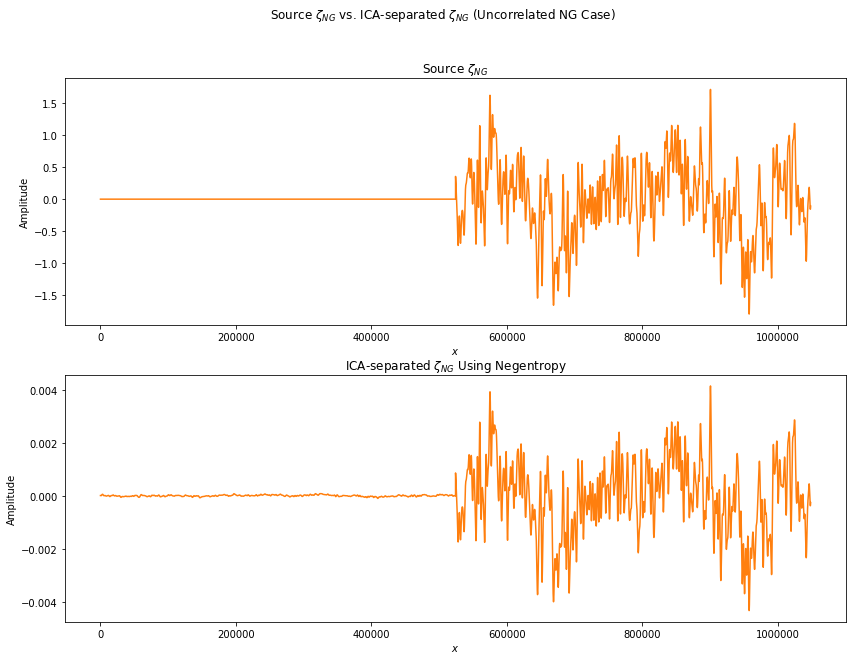

In [45]:
# Non-Gaussian component plots

plt.figure(figsize=(14,10))
plt.suptitle(r'Source $\zeta_{NG}$ vs. ICA-separated $\zeta_{NG}$ (Uncorrelated NG Case)')

# Original NG component
plt.subplot(211)
plt.plot(source2, color='C1')
plt.title(r'Source $\zeta_{NG}$')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# plt.subplot(212)
# plt.plot(kurt_comp1, color='C1')
# plt.title(r'ICA-separated $\zeta_{NG}$ Using Kurtosis')
# plt.xlabel(r'$x$')
# plt.ylabel("Amplitude")

plt.subplot(212)
plt.plot(negen_comp1, color='C1')
plt.title(r'ICA-separated $\zeta_{NG}$ Using Negentropy')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

if correlated:
    plt.savefig('ICA_corr_ng.png')
else:
    plt.savefig('ICA_uncorr_ng.png')

## Plot the difference between the fields

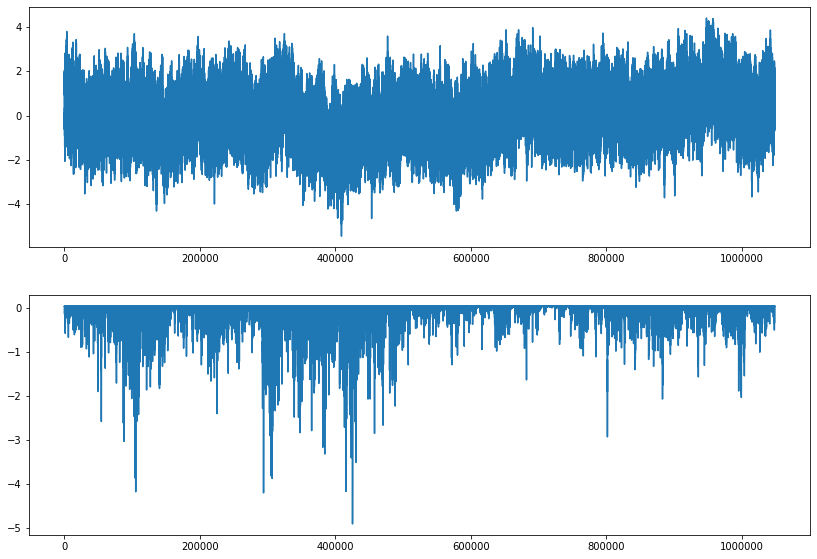

In [141]:
plt.figure(figsize=(14,15))
# plt.suptitle(r'Source $\zeta_{NG}$ vs. ICA-extracted $\zeta_{NG}$ ')

# norm_source_g = (source_g - np.mean(source_g))/(np.var(source_g))
# norm_source_ng = (source_ng - np.mean(source_ng))/(np.var(source_ng))
# norm_kurt_comp1 = (kurt_comp1 - np.mean(kurt_comp1))/(np.var(kurt_comp1))
# norm_kurt_comp2 = (kurt_comp2 - np.mean(kurt_comp2))/(np.var(kurt_comp2))

norm_source_g = (source_g - np.mean(source_g))
norm_source_ng = (source_ng - np.mean(source_ng))
norm_kurt_comp1 = (kurt_comp1 - np.mean(kurt_comp1))
norm_kurt_comp2 = (kurt_comp2 - np.mean(kurt_comp2))

# Original NG component
plt.subplot(311)
plt.plot((norm_kurt_comp2 - norm_source_g))
# plt.title(r'Source $\zeta_{NG}$')
# plt.xlabel(r'$x$')
# plt.ylabel("Amplitude")

plt.subplot(312)
plt.plot((norm_kurt_comp1 - norm_source_ng))
# plt.title(r'$\zeta_{NG}$ extracted using Kurtosis')
# plt.xlabel(r'$x$')
# plt.ylabel("Amplitude")

# if correlated:
#     plt.savefig('ICA_corr_ng.png')
# else:
#     plt.savefig('ICA_uncorr_ng.png')

## Plot scatter of source and extracted NG 

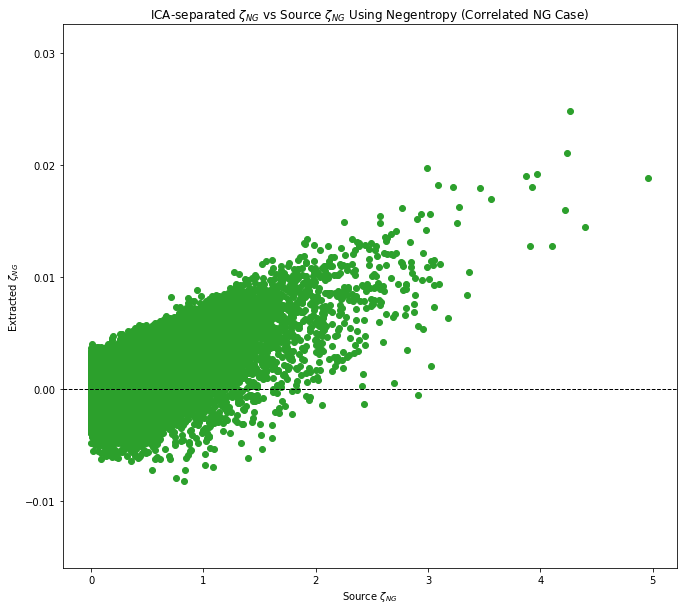

In [41]:
plt.figure(figsize=(11,10))

plt.subplot(211)
plt.axhline(color='black', ls='--', linewidth=1)
plt.scatter(source_ng, kurt_comp1, color='C1')
plt.title(r'Kurtosis-extracted $\zeta_{NG}$ vs Source $\zeta_{NG}$')
plt.xlabel(r'Source $\zeta_{NG}$')
plt.ylabel(r'Extracted $\zeta_{NG}$')
# plt.ylim(-0.01, 0.02) 


# # plt.subplot(212)
# plt.axhline(color='black', ls='--', linewidth=1)
# plt.scatter(source_ng, negen_comp1, color='C2')
# plt.title(r'ICA-separated $\zeta_{{NG}}$ vs Source $\zeta_{{NG}}$ Using Negentropy ({0} NG Case)'.format(t))
# plt.xlabel(r'Source $\zeta_{NG}$')
# plt.ylabel(r'Extracted $\zeta_{NG}$')
# # plt.ylim(-0.01, 0.02) 

# if correlated:
#     plt.savefig('ICA_corr_scatter.png')
# else:
#     plt.savefig('ICA_uncorr_scatter.png')

## Plot the PDFs

/Users/JawanHaider/opt/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[Text(0, 0.5, 'Probability Difference')]

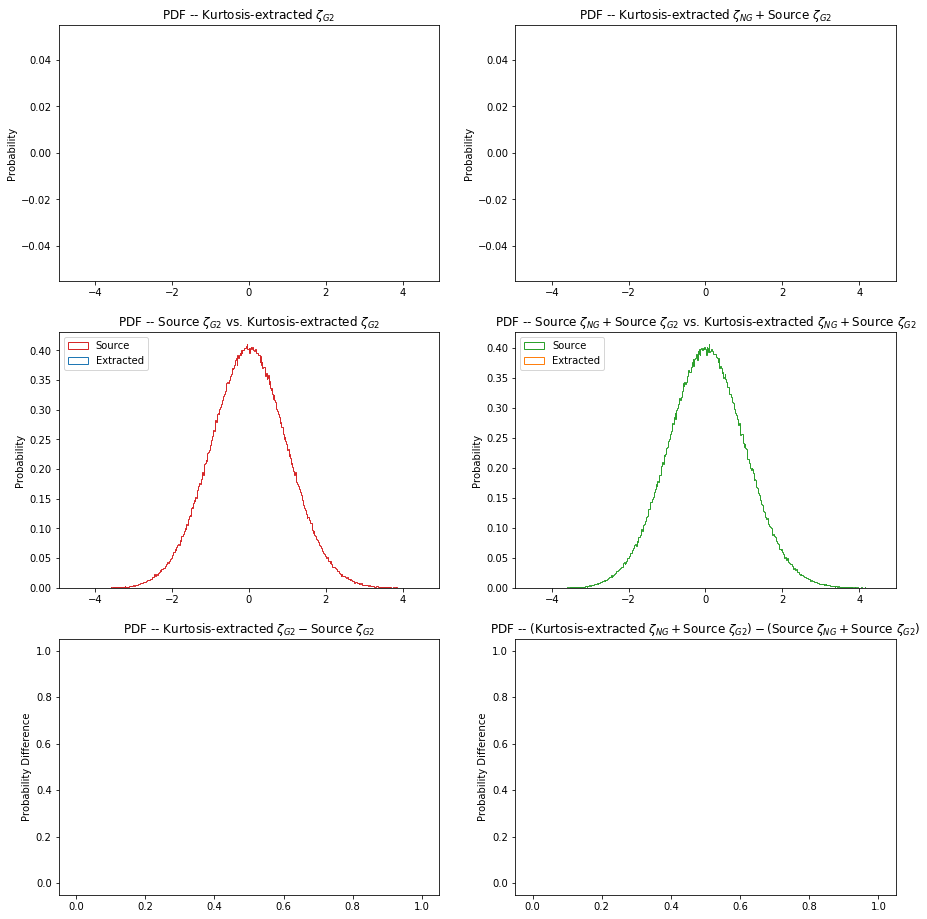

In [46]:
# Plot PDFs for kurtosis-extracted components

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,16))

hist_binvalues = np.linspace(-4.5, 4.5, 500)
source_g_pdf = np.histogram(source_g, bins=hist_binvalues, density=True)
source_total_pdf = np.histogram(source_ng + source_g, bins=hist_binvalues, density=True)

ax1.set_title(r'PDF -- Kurtosis-extracted $\zeta_{{{0}}}$'.format(k))
kurt_comp2_pdf = ax1.hist(kurt_comp2, bins=hist_binvalues, density=True, histtype='step')
ax1.set(ylabel="Probability")

ax2.set_title(r'PDF -- Kurtosis-extracted $\zeta_{{NG}} +$Source $\zeta_{{{0}}}$'.format(k))
kurt_comp1_pdf = ax2.hist(kurt_comp1 + source_g, bins=hist_binvalues, density=True, histtype='step', color='C1')
ax2.set(ylabel="Probability")

ax3.set_title(r'PDF -- Source $\zeta_{{{0}}}$ vs. Kurtosis-extracted $\zeta_{{{0}}}$'.format(k))
ax3.hist(source_g, bins=hist_binvalues, density=True, label=r'Source'.format(k), histtype='step', color='C3')
ax3.hist(kurt_comp2, bins=hist_binvalues, density=True, label=r'Extracted'.format(k), histtype='step')
ax3.legend(loc='upper left')
ax3.set(ylabel=r"Probability")

ax4.set_title(r'PDF -- Source $\zeta_{{NG}} +$Source $\zeta_{{{0}}}$ vs. Kurtosis-extracted $\zeta_{{NG}} +$Source $\zeta_{{{0}}}$'.format(k))
ax4.hist(source_ng + source_g, bins=hist_binvalues, density=True, label=r'Source', histtype='step', color='C2')
ax4.hist(kurt_comp1 + source_g, bins=hist_binvalues, density=True, label=r'Extracted', histtype='step', color='C1')
ax4.legend(loc='upper left')
ax4.set(ylabel=r"Probability")

ax5.set_title(r'PDF -- Kurtosis-extracted $\zeta_{{{0}}} - $Source $\zeta_{{{0}}}$'.format(k))
ax5.plot(kurt_comp2_pdf[1][1:], (kurt_comp2_pdf[0]-source_g_pdf[0]), label=r'Source', color='C4')
ax5.set(ylabel=r"Probability Difference")

ax6.set_title(r'PDF -- (Kurtosis-extracted $\zeta_{{NG}} +$Source $\zeta_{{{0}}}) - ($Source $\zeta_{{NG}} +$Source $\zeta_{{{0}}})$'.format(k))
ax6.plot(kurt_comp1_pdf[1][1:], (kurt_comp1_pdf[0]-source_total_pdf[0]), label=r'Source', color='C4')
ax6.set(ylabel=r"Probability Difference")

# plt.savefig('UncorrNG_PDFs.png')

[Text(0, 0.5, 'Probability Difference')]

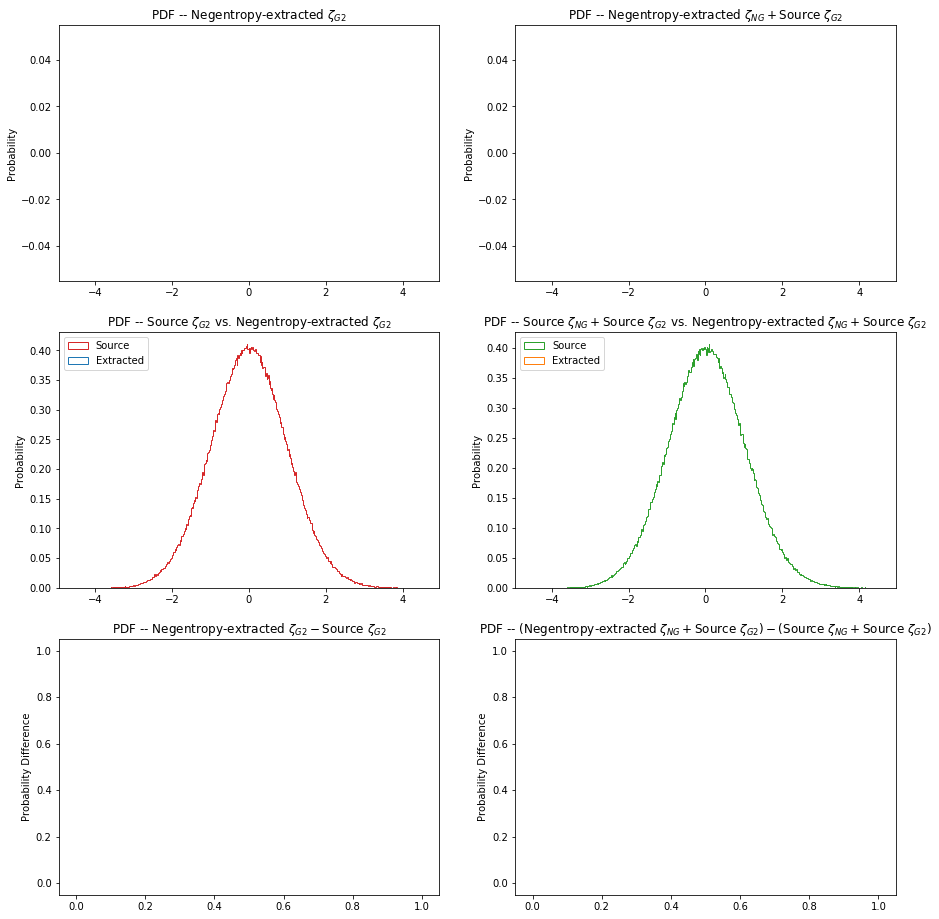

In [47]:
# Plot PDFs for negentropy-extracted components

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,16))

hist_binvalues = np.linspace(-4.5, 4.5, 500)
source_g_pdf = np.histogram(source_g, bins=hist_binvalues, density=True)
source_total_pdf = np.histogram(source_ng + source_g, bins=hist_binvalues, density=True)

ax1.set_title(r'PDF -- Negentropy-extracted $\zeta_{{{0}}}$'.format(k))
negen_comp2_pdf = ax1.hist(negen_comp2, bins=hist_binvalues, density=True, histtype='step')
ax1.set(ylabel="Probability")

ax2.set_title(r'PDF -- Negentropy-extracted $\zeta_{{NG}} +$Source $\zeta_{{{0}}}$'.format(k))
negen_comp1_pdf = ax2.hist(negen_comp1 + source_g, bins=hist_binvalues, density=True, histtype='step', color='C1')
ax2.set(ylabel="Probability")

ax3.set_title(r'PDF -- Source $\zeta_{{{0}}}$ vs. Negentropy-extracted $\zeta_{{{0}}}$'.format(k))
ax3.hist(source_g, bins=hist_binvalues, density=True, label=r'Source'.format(k), histtype='step', color='C3')
ax3.hist(negen_comp2, bins=hist_binvalues, density=True, label=r'Extracted'.format(k), histtype='step')
ax3.legend(loc='upper left')
ax3.set(ylabel=r"Probability")

ax4.set_title(r'PDF -- Source $\zeta_{{NG}} +$Source $\zeta_{{{0}}}$ vs. Negentropy-extracted $\zeta_{{NG}} +$Source $\zeta_{{{0}}}$'.format(k))
ax4.hist(source_ng + source_g, bins=hist_binvalues, density=True, label=r'Source', histtype='step', color='C2')
ax4.hist(negen_comp1 + source_g, bins=hist_binvalues, density=True, label=r'Extracted', histtype='step', color='C1')
ax4.legend(loc='upper left')
ax4.set(ylabel=r"Probability")

ax5.set_title(r'PDF -- Negentropy-extracted $\zeta_{{{0}}} - $Source $\zeta_{{{0}}}$'.format(k))
ax5.plot(negen_comp2_pdf[1][1:], (negen_comp2_pdf[0]-source_g_pdf[0]), label=r'Source', color='C4')
ax5.set(ylabel=r"Probability Difference")

ax6.set_title(r'PDF -- (Negentropy-extracted $\zeta_{{NG}} +$Source $\zeta_{{{0}}}) - ($Source $\zeta_{{NG}} +$Source $\zeta_{{{0}}})$'.format(k))
ax6.plot(negen_comp1_pdf[1][1:], (negen_comp1_pdf[0]-source_total_pdf[0]), label=r'Source', color='C4')
ax6.set(ylabel=r"Probability Difference")

# plt.savefig('UncorrNG_PDFs.png')